In [ ]:
# GTM Package including GTM and the plot functions
from gtm import *
# Helper functions to create simulation data and analyze it
from demos.pyvinecopulib_simulation_helpers import *
# Sample Copulas Package
import pyvinecopulib as pv
import numpy as np
# Other Stuff
import torch
from torch.utils.data import Dataset, DataLoader
from demos.dataset_helpers import Generic_Dataset
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

/Users/matthiasherp/anaconda3/envs/mctm_pytorch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
set_seeds(1)

### 1. Sample Data

In [3]:
rvine_structure = pv.RVineStructure.simulate(10)

In [4]:
D = 10  # dimension
pair_copulas = sample_random_pair_copulas(D,Independence_tree=3)

In [5]:
vine_model = pv.Vinecop.from_structure(structure=rvine_structure, pair_copulas=pair_copulas)


In [6]:
df = compute_conditional_dependence_table(vine_model)
df

,tree,edge,conditioned variables,conditioning variables,var_types,family,rotation,parameters,df,tau,conditioned variable 1,conditioned variable 2,var_row,var_col,dependence
0,1,1,3 2,,"c, c",Joe,270.0,5.44,1.0,-0.70,3,2,3,2,1
1,1,2,9 8,,"c, c",Student,0.0,"0.42, 2.00",2.0,0.28,9,8,9,8,1
2,1,3,4 2,,"c, c",Gaussian,0.0,-0.34,1.0,-0.22,4,2,4,2,1
3,1,4,1 5,,"c, c",Joe,180.0,3.46,1.0,0.57,1,5,5,1,1
4,1,5,10 2,,"c, c",Frank,0.0,-5.18,1.0,-0.47,10,2,10,2,1
5,1,6,7 8,,"c, c",Frank,0.0,-3.92,1.0,-0.38,7,8,8,7,1
6,1,7,6 8,,"c, c",Frank,0.0,-3.04,1.0,-0.31,6,8,8,6,1
7,1,8,5 2,,"c, c",Frank,0.0,5.17,1.0,0.47,5,2,5,2,1
8,1,9,8 2,,"c, c",Student,0.0,"-0.36, 2.00",2.0,-0.23,8,2,8,2,1
9,2,1,3 8,2,"c, c",Joe,270.0,3.67,1.0,-0.59,3,8,8,3,1


In [7]:
#creating a table to copare the true dependence structure later on to what the gtm learned
df_true_structure = df[["tree","edge","conditioned variables", "conditioned variable 1", "conditioned variable 2", "dependence", "var_row", "var_col"]]
df_true_structure_sub = df_true_structure[["var_row", "var_col", "dependence"]]
df_true_structure_sub["var_row"] = df_true_structure_sub["var_row"] - 1
df_true_structure_sub["var_col"] = df_true_structure_sub["var_col"] - 1

/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_11787/3150062370.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_true_structure_sub["var_row"] = df_true_structure_sub["var_row"] - 1
/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_11787/3150062370.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_true_structure_sub["var_col"] = df_true_structure_sub["var_col"] - 1


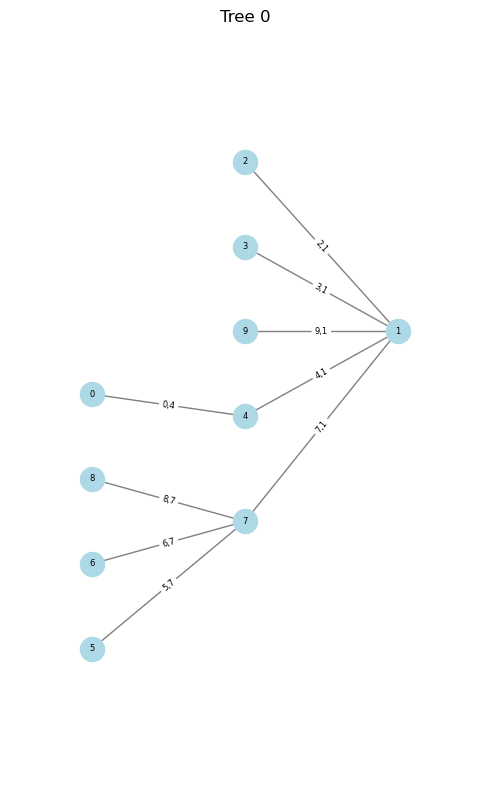

In [8]:
vine_model.plot(tree=[0])

In [9]:
# Train
N_train = 2000
simulated_data_uniform_train = vine_model.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = vine_model.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = vine_model.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [10]:
loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_11787/1520218578.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_11787/1520218578.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_11787/1520218578.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

In [11]:
copula_pv_est = vine_model
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [12]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_11787/2452348847.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(means,vars).log_prob(torch.tensor(simulated_data_train)).sum(1)
/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_11787/2452348847.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(means,vars).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_11787/2452348847.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requir

In [13]:
#_ = plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

In [14]:
#_ = plot_marginals(simulated_data_train)

In [ ]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

In [16]:
# Here you can see that we load the full data, so not batches
# Model is just implemented with dataloaders because that is eeded for huge datasets in bioinformatics
data_iter = iter(dataloader_train)
sample = next(data_iter)
sample.size()

torch.Size([2000, 10])

### 2. Define Model

In [17]:
model = GTM(
    transformation_spline_range=list([[-10], [10]]), 
    decorrelation_spline_range=list([[-10], [10]]), 
    degree_decorrelation=5,
    degree_transformations=10,
    num_decorr_layers=4,
    num_trans_layers=1,
    number_variables=10,
    calc_method_bspline="deBoor",
    spline_decorrelation="bernstein", #"bspline", #"bernstein",
    spline_transformation="bernstein",
    affine_decorr_layer=False,
    span_restriction="reluler",
    device="cpu") 

/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_layers/transformation_layer.py:58: UserWarning: Warning: Varying Spline Degree for each Dimension is not implemented for Bernstein, only for B-Spline.
  warnings.warn("Warning: Varying Spline Degree for each Dimension is not implemented for Bernstein, only for B-Spline.")
/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_layers/transformation_layer.py:63: UserWarning: Bernstein polynomial penalization is not implemented yet. only returns zeros hardcoded in bernstein_prediction.py fct
  warnings.warn("Bernstein polynomial penalization is not implemented yet. only returns zeros hardcoded in bernstein_prediction.py fct")
/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_splines/bernstein_prediction_vectorized.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sour

### 3. Hyperparameter Tune and Train Model

In [56]:
study = model.hyperparameter_tune_penalties( 
                                train_dataloader=dataloader_train, 
                                validate_dataloader=dataloader_validate, 
                                penvalueridge = [0], #["sample"],
                                penfirstridge = ["sample"],
                                pensecondridge = ["sample"],
                                ctm_pensecondridge = [0], #["sample"],
                                lambda_penalty_params = [0], #["sample"], #[0],
                                train_covariates=False, 
                                validate_covariates=False, 
                                adaptive_lasso_weights_matrix = False,
                                learning_rate=1, 
                                iterations=1000, 
                                patience=5, 
                                min_delta=1e-7, 
                                optimizer='LBFGS', 
                                lambda_penalty_mode="square", 
                                objective_type="negloglik", 
                                seperate_copula_training=False,
                                max_batches_per_iter=False,
                                tuning_mode="optuna",
                                cross_validation_folds=False,
                                random_state_KFold=42,
                                device=None,
                                pretrained_transformation_layer=False,
                                n_trials=20,
                                temp_folder=".", 
                                study_name=None)
    
penalty_params=torch.FloatTensor([
                            0, #study.best_params["penvalueridge"],
                            study.best_params["penfirstridge"],
                            study.best_params["pensecondridge"],
                            0 #study.best_params["ctm_pensecondridge"]
                              ])
adaptive_lasso_weights_matrix = False
lambda_penalty_params= False #study.best_params["lambda_penalty_params"] #False

/Users/matthiasherp/anaconda3/envs/mctm_pytorch/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-23 14:40:52,924] A new study created in RDB with name: no-name-dffe3476-fe2b-43fa-95c5-287ff99c57da


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 16.906268195445964   pensecondridge_opt: 10.304419198248382   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 20%|██        | 202/1000 [00:32<02:07,  6.28it/s]
[I 2025-05-23 14:41:25,204] Trial 0 finished with value: -7.169945240020752 and parameters: {'penfirstridge': 16.906268195445964, 'pensecondridge': 10.304419198248382}. Best is trial 0 with value: -7.169945240020752.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 13.399828001950633   pensecondridge_opt: 0.8235903833827221   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 31%|███       | 306/1000 [00:46<01:44,  6.64it/s]
[I 2025-05-23 14:42:11,404] Trial 1 finished with value: -6.975780010223389 and parameters: {'penfirstridge': 13.399828001950633, 'pensecondridge': 0.8235903833827221}. Best is trial 1 with value: -6.975780010223389.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 29.28271661603939   pensecondridge_opt: 6.991828377837199   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  3%|▎         | 27/1000 [00:04<02:40,  6.05it/s]
[I 2025-05-23 14:42:15,946] Trial 2 finished with value: -8.592982292175293 and parameters: {'penfirstridge': 29.28271661603939, 'pensecondridge': 6.991828377837199}. Best is trial 1 with value: -6.975780010223389.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 8.467810536227393   pensecondridge_opt: 14.701210033843113   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 25%|██▌       | 254/1000 [00:36<01:48,  6.89it/s]
[I 2025-05-23 14:42:52,917] Trial 3 finished with value: -6.964595794677734 and parameters: {'penfirstridge': 8.467810536227393, 'pensecondridge': 14.701210033843113}. Best is trial 3 with value: -6.964595794677734.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 26.559433619628983   pensecondridge_opt: 23.229511846182668   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 16%|█▌        | 155/1000 [00:21<01:58,  7.14it/s]
[I 2025-05-23 14:43:14,708] Trial 4 finished with value: -7.3560566902160645 and parameters: {'penfirstridge': 26.559433619628983, 'pensecondridge': 23.229511846182668}. Best is trial 3 with value: -6.964595794677734.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 27.572481976786186   pensecondridge_opt: 3.351197308102136   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 12%|█▏        | 115/1000 [00:16<02:10,  6.79it/s]
[I 2025-05-23 14:43:31,714] Trial 5 finished with value: -7.708654880523682 and parameters: {'penfirstridge': 27.572481976786186, 'pensecondridge': 3.351197308102136}. Best is trial 3 with value: -6.964595794677734.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 10.887684267540102   pensecondridge_opt: 5.815606251320858   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  6%|▌         | 55/1000 [00:07<02:14,  7.02it/s]
[I 2025-05-23 14:43:39,635] Trial 6 finished with value: -7.962723255157471 and parameters: {'penfirstridge': 10.887684267540102, 'pensecondridge': 5.815606251320858}. Best is trial 3 with value: -6.964595794677734.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 24.1483827666606   pensecondridge_opt: 20.78382324708186   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 19%|█▉        | 193/1000 [00:27<01:55,  6.96it/s]
[I 2025-05-23 14:44:07,454] Trial 7 finished with value: -7.280590057373047 and parameters: {'penfirstridge': 24.1483827666606, 'pensecondridge': 20.78382324708186}. Best is trial 3 with value: -6.964595794677734.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 11.266841862788063   pensecondridge_opt: 4.225987557219937   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 14%|█▎        | 137/1000 [00:20<02:07,  6.76it/s]
[I 2025-05-23 14:44:27,812] Trial 8 finished with value: -7.190523624420166 and parameters: {'penfirstridge': 11.266841862788063, 'pensecondridge': 4.225987557219937}. Best is trial 3 with value: -6.964595794677734.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 29.685195523380198   pensecondridge_opt: 24.869794883999322   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  8%|▊         | 79/1000 [00:11<02:13,  6.88it/s]
[I 2025-05-23 14:44:39,382] Trial 9 finished with value: -8.03335952758789 and parameters: {'penfirstridge': 29.685195523380198, 'pensecondridge': 24.869794883999322}. Best is trial 3 with value: -6.964595794677734.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 4.6984171537176955   pensecondridge_opt: 29.84479001342971   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 12%|█▏        | 118/1000 [00:16<02:03,  7.16it/s]
[I 2025-05-23 14:44:55,939] Trial 10 finished with value: -7.404181480407715 and parameters: {'penfirstridge': 4.6984171537176955, 'pensecondridge': 29.84479001342971}. Best is trial 3 with value: -6.964595794677734.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 7.205473812885041   pensecondridge_opt: 19.40826156856253   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 18%|█▊        | 183/1000 [00:25<01:52,  7.23it/s]
[I 2025-05-23 14:45:21,329] Trial 11 finished with value: -7.140079975128174 and parameters: {'penfirstridge': 7.205473812885041, 'pensecondridge': 19.40826156856253}. Best is trial 3 with value: -6.964595794677734.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 2.9568730423136405   pensecondridge_opt: 3.324152142007751   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 17%|█▋        | 169/1000 [00:23<01:56,  7.15it/s]
[I 2025-05-23 14:45:45,061] Trial 12 finished with value: -6.959198951721191 and parameters: {'penfirstridge': 2.9568730423136405, 'pensecondridge': 3.324152142007751}. Best is trial 12 with value: -6.959198951721191.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 0.38354107548009786   pensecondridge_opt: 7.404244079609736   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 22%|██▏       | 218/1000 [00:31<01:51,  7.02it/s]
[I 2025-05-23 14:46:16,196] Trial 13 finished with value: -6.84974479675293 and parameters: {'penfirstridge': 0.38354107548009786, 'pensecondridge': 7.404244079609736}. Best is trial 13 with value: -6.84974479675293.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 2.468947501500691   pensecondridge_opt: 5.7021863766492835   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 17%|█▋        | 173/1000 [00:24<01:56,  7.10it/s]
[I 2025-05-23 14:46:40,641] Trial 14 finished with value: -6.9815239906311035 and parameters: {'penfirstridge': 2.468947501500691, 'pensecondridge': 5.7021863766492835}. Best is trial 13 with value: -6.84974479675293.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 0.2759254392434347   pensecondridge_opt: 16.971261449481013   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 19%|█▉        | 189/1000 [00:26<01:52,  7.20it/s]
[I 2025-05-23 14:47:06,983] Trial 15 finished with value: -7.079928874969482 and parameters: {'penfirstridge': 0.2759254392434347, 'pensecondridge': 16.971261449481013}. Best is trial 13 with value: -6.84974479675293.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 5.025490545884263   pensecondridge_opt: 0.7721753066744625   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 13%|█▎        | 131/1000 [00:19<02:07,  6.79it/s]
[I 2025-05-23 14:47:26,355] Trial 16 finished with value: -7.05792760848999 and parameters: {'penfirstridge': 5.025490545884263, 'pensecondridge': 0.7721753066744625}. Best is trial 13 with value: -6.84974479675293.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 0.3981563266873863   pensecondridge_opt: 9.36999008667733   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 23%|██▎       | 229/1000 [00:32<01:48,  7.13it/s]
[I 2025-05-23 14:47:58,566] Trial 17 finished with value: -6.859644412994385 and parameters: {'penfirstridge': 0.3981563266873863, 'pensecondridge': 9.36999008667733}. Best is trial 13 with value: -6.84974479675293.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 2.109382522723287   pensecondridge_opt: 12.35839047693668   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 18%|█▊        | 180/1000 [00:25<01:54,  7.14it/s]
[I 2025-05-23 14:48:23,863] Trial 18 finished with value: -7.052333831787109 and parameters: {'penfirstridge': 2.109382522723287, 'pensecondridge': 12.35839047693668}. Best is trial 13 with value: -6.84974479675293.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 12.838999323253626   pensecondridge_opt: 24.80853876130514   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  8%|▊         | 84/1000 [00:11<02:09,  7.08it/s]
[I 2025-05-23 14:48:35,814] Trial 19 finished with value: -7.795208930969238 and parameters: {'penfirstridge': 12.838999323253626, 'pensecondridge': 24.80853876130514}. Best is trial 13 with value: -6.84974479675293.


hyperparameter_tuning done


In [31]:
model = GTM(
    transformation_spline_range=list([[-10], [10]]), 
    decorrelation_spline_range=list([[-10], [10]]), 
    degree_decorrelation=20,
    degree_transformations=15,
    num_decorr_layers=4,
    num_trans_layers=1,
    number_variables=10,
    calc_method_bspline="deBoor",
    spline_decorrelation="bspline", #"bspline", #"bernstein",
    affine_decorr_layer=False,
    span_restriction="reluler",
    device="cpu") 

In [19]:
penalty_params=torch.FloatTensor([
                            0, #study.best_params["penvalueridge"],
                            0,
                            0,
                            0 #study.best_params["ctm_pensecondridge"]
                              ])
adaptive_lasso_weights_matrix = False
lambda_penalty_params= False #study.best_params["lambda_penalty_params"] #False

In [20]:
# pretrain the marginal transformations
_ = model.pretrain_tranformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_params=penalty_params)

/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_model/gtm.py:296: UserWarning: Optimiser for pretrain_tranformation_layer is always LBFGS. If this is an issue change the code.
  warnings.warn("Optimiser for pretrain_tranformation_layer is always LBFGS. If this is an issue change the code.")
  2%|▏         | 24/1000 [00:00<00:30, 31.68it/s]


In [21]:
# train the joint model
_ = model.__train__(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS", learning_rate=1,
                penalty_params=penalty_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, lambda_penalty_params=lambda_penalty_params, 
                max_batches_per_iter=False)

 16%|█▋        | 164/1000 [00:25<02:11,  6.36it/s]


### 4. Compare Fit to Benchmarks

In [21]:
log_likelihood_train_gtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model.log_likelihood(simulated_data_test)

In [22]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)  # 0 to do mean across dim 0 not globally
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [23]:
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )

print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD GTM      Train Data:  0.8186
KLD Gaussian Train Data:  3.5949
KLD Copula   Train Data:  0.0342
KLD GTM      Test  Data:  1.1349
KLD Gaussian Test  Data:  3.6777
KLD Copula   Test  Data:  0.0862


In [24]:
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )

print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD GTM      Train Data:  0.8186
KLD Gaussian Train Data:  3.5949
KLD Copula   Train Data:  0.0342
KLD GTM      Test  Data:  1.1349
KLD Gaussian Test  Data:  3.6777
KLD Copula   Test  Data:  0.0862


In [25]:
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )

print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD GTM      Train Data:  0.8186
KLD Gaussian Train Data:  3.5949
KLD Copula   Train Data:  0.0342
KLD GTM      Test  Data:  1.1349
KLD Gaussian Test  Data:  3.6777
KLD Copula   Test  Data:  0.0862


In [26]:
stop

NameError: name 'stop' is not defined

In [ ]:
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )

print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD GTM      Train Data:  0.9591
KLD Gaussian Train Data:  3.4334
KLD Copula   Train Data:  0.0186
KLD GTM      Test  Data:  1.1836
KLD Gaussian Test  Data:  3.4478
KLD Copula   Test  Data:  0.0467


In [ ]:
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )

print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD GTM      Train Data:  0.8188
KLD Gaussian Train Data:  3.4334
KLD Copula   Train Data:  0.0186
KLD GTM      Test  Data:  1.082
KLD Gaussian Test  Data:  3.4478
KLD Copula   Test  Data:  0.0467


In [ ]:
# save model
#torch.save(model, "10D_rvine_model_state_dict.pth")
#model = torch.load("./10D_rvine_model_state_dict.pth")

In [ ]:
stop

NameError: name 'stop' is not defined

### 5. Evaluate and Plot GTM Results

In [28]:
model.approximate_transformation_inverse()

In [29]:
synthetic_samples = model.sample(2000)
conditional_correlation_matrix_train = model.compute_correlation_matrix(synthetic_samples)

In [30]:
#_ = plot_densities(synthetic_samples, x_lim=[-4,4], y_lim=[-4,4])

In [ ]:
#_ = plot_metric_scatter(data=synthetic_samples,metric=conditional_correlation_matrix_train,metric_type="precision_matrix")

#### does the GTM identify the conditional independence structure?

In [ ]:
simulated_data_test.size()

torch.Size([20000, 10])

In [ ]:
conditional_independence_table = model.compute_conditional_independence_table(
                                        y = simulated_data_test[:5000,:], #None
                                        x = False,
                                        evaluation_data_type = "data", #"samples_from_model",
                                        num_processes=4,
                                        sample_size = 1000,
                                        num_points_quad=15,
                                        optimized=True,
                                        copula_only=False,
                                        min_val=-6,
                                        max_val=6)

Processing row 0 with var_row_num 1 and var_col_num 0.
Processing row 6 with var_row_num 4 and var_col_num 0.
Processing row 9 with var_row_num 4 and var_col_num 3.
Processing row 3 with var_row_num 3 and var_col_num 0.


/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:404: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3687.)
  t=knots.T,
/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:404: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/sr

Processing row 4 with var_row_num 3 and var_col_num 1.
Processing row 7 with var_row_num 4 and var_col_num 1.
Processing row 1 with var_row_num 2 and var_col_num 0.
Processing row 10 with var_row_num 5 and var_col_num 0.
Processing row 5 with var_row_num 3 and var_col_num 2.
Processing row 8 with var_row_num 4 and var_col_num 2.
Processing row 2 with var_row_num 2 and var_col_num 1.
Processing row 11 with var_row_num 5 and var_col_num 1.
Processing row 12 with var_row_num 5 and var_col_num 2.
Processing row 15 with var_row_num 6 and var_col_num 0.
Processing row 18 with var_row_num 6 and var_col_num 3.
Processing row 21 with var_row_num 7 and var_col_num 0.
Processing row 13 with var_row_num 5 and var_col_num 3.
Processing row 16 with var_row_num 6 and var_col_num 1.
Processing row 19 with var_row_num 6 and var_col_num 4.
Processing row 22 with var_row_num 7 and var_col_num 1.
Processing row 14 with var_row_num 5 and var_col_num 4.
Processing row 17 with var_row_num 6 and var_col_num 2

In [ ]:
# merging together computed metrics for conditional independence table and actual structure of the simulation data for comparison
merged = pd.merge(
    conditional_independence_table,
    df_true_structure_sub,
    on=["var_row", "var_col"] # or "inner", "left", depending on your needs
)
merged.shape


(45, 9)

In [ ]:
merged.sort_values("iae",ascending=False) #.sort_values("abs_mean",ascending=False) #.sort_values("iae",ascending=False)

,var_row,var_col,precision_abs_mean,precision_square_mean,cond_correlation_abs_mean,cond_correlation_square_mean,kld,iae,dependence
26,7,5,4.241405,20.432474,0.491744,0.270377,0.796407,2.292149,1
22,7,1,6.661479,45.859467,0.835930,0.699956,2.688869,1.930084,1
24,7,3,2.556951,7.173597,0.424617,0.183733,0.732047,1.625738,1
11,5,1,2.491431,7.482593,0.425003,0.208859,0.605241,1.299844,1
25,7,4,4.028057,16.413799,0.632437,0.410131,1.381922,1.013068,1
4,3,1,0.818303,0.738617,0.213761,0.050335,0.233519,0.735718,0
7,4,1,1.738819,3.156819,0.406261,0.169761,0.389400,0.714454,0
14,5,4,2.834680,8.343678,0.605658,0.380874,0.762820,0.686833,1
13,5,3,1.846897,5.609583,0.381413,0.187701,2.322047,0.582277,1
19,6,4,1.864107,4.081544,0.618710,0.394771,0.720151,0.560343,1


In [ ]:
merged.sort_values("cond_correlation_abs_mean",ascending=False)

,var_row,var_col,precision_abs_mean,precision_square_mean,cond_correlation_abs_mean,cond_correlation_square_mean,kld,iae,dependence
22,7,1,6.661479,45.859467,0.835930,0.699956,2.688869,1.930084,1
30,8,2,1.273742,1.787008,0.682809,0.478658,0.318496,0.435588,1
25,7,4,4.028057,16.413799,0.632437,0.410131,1.381922,1.013068,1
19,6,4,1.864107,4.081544,0.618710,0.394771,0.720151,0.560343,1
14,5,4,2.834680,8.343678,0.605658,0.380874,0.762820,0.686833,1
26,7,5,4.241405,20.432474,0.491744,0.270377,0.796407,2.292149,1
11,5,1,2.491431,7.482593,0.425003,0.208859,0.605241,1.299844,1
24,7,3,2.556951,7.173597,0.424617,0.183733,0.732047,1.625738,1
7,4,1,1.738819,3.156819,0.406261,0.169761,0.389400,0.714454,0
13,5,3,1.846897,5.609583,0.381413,0.187701,2.322047,0.582277,1


In [ ]:
merged.corr("spearman")

,var_row,var_col,precision_abs_mean,precision_square_mean,cond_correlation_abs_mean,cond_correlation_square_mean,kld,iae,dependence
var_row,1.000000,0.468889,-0.139536,-0.160982,-0.092313,-0.102770,-0.204142,-0.257092,-0.051740
var_col,0.468889,1.000000,0.111495,0.118355,0.015918,0.024444,0.068203,0.059544,0.067797
precision_abs_mean,-0.139536,0.111495,1.000000,0.997365,0.968116,0.972596,0.952042,0.975494,0.656440
precision_square_mean,-0.160982,0.118355,0.997365,1.000000,0.958762,0.965744,0.957576,0.975626,0.663498
cond_correlation_abs_mean,-0.092313,0.015918,0.968116,0.958762,1.000000,0.998024,0.911858,0.930040,0.656440
cond_correlation_square_mean,-0.102770,0.024444,0.972596,0.965744,0.998024,1.000000,0.923452,0.936891,0.670557
kld,-0.204142,0.068203,0.952042,0.957576,0.911858,0.923452,1.000000,0.947958,0.670557
iae,-0.257092,0.059544,0.975494,0.975626,0.930040,0.936891,0.947958,1.000000,0.631735
dependence,-0.051740,0.067797,0.656440,0.663498,0.656440,0.670557,0.670557,0.631735,1.000000


In [ ]:
merged.corr("pearson")

,var_row,var_col,precision_abs_mean,precision_square_mean,cond_correlation_abs_mean,cond_correlation_square_mean,kld,iae,dependence
var_row,1.000000,0.500000,-0.021973,0.029770,-0.052468,-0.006787,-0.051600,-0.064045,0.006910
var_col,0.500000,1.000000,0.019489,-0.008769,-0.021231,-0.009877,-0.003765,0.018798,0.013820
precision_abs_mean,-0.021973,0.019489,1.000000,0.934831,0.884478,0.894093,0.859607,0.911933,0.561281
precision_square_mean,0.029770,-0.008769,0.934831,1.000000,0.722816,0.808208,0.830003,0.812133,0.426537
cond_correlation_abs_mean,-0.052468,-0.021231,0.884478,0.722816,1.000000,0.963535,0.770452,0.775812,0.639361
cond_correlation_square_mean,-0.006787,-0.009877,0.894093,0.808208,0.963535,1.000000,0.798495,0.732240,0.587927
kld,-0.051600,-0.003765,0.859607,0.830003,0.770452,0.798495,1.000000,0.705796,0.521010
iae,-0.064045,0.018798,0.911933,0.812133,0.775812,0.732240,0.705796,1.000000,0.539679
dependence,0.006910,0.013820,0.561281,0.426537,0.639361,0.587927,0.521010,0.539679,1.000000


In [ ]:
auc_iae = roc_auc_score(merged["dependence"], merged["iae"])
auc_kld = roc_auc_score(merged["dependence"], merged["kld"])
auc_corr = roc_auc_score(merged["dependence"], merged["cond_correlation_abs_mean"])
auc_pmat = roc_auc_score(merged["dependence"], merged["precision_abs_mean"])
print("AUC IAE                    :",auc_iae)
print("AUC KLD                    :",auc_kld)
print("AUC Conditional Correlation:",auc_corr)
print("AUC Precision Matrix       :",auc_pmat)

AUC IAE                    : 0.8760504201680673
AUC KLD                    : 0.8991596638655462
AUC Conditional Correlation: 0.8907563025210083
AUC Precision Matrix       : 0.8907563025210083


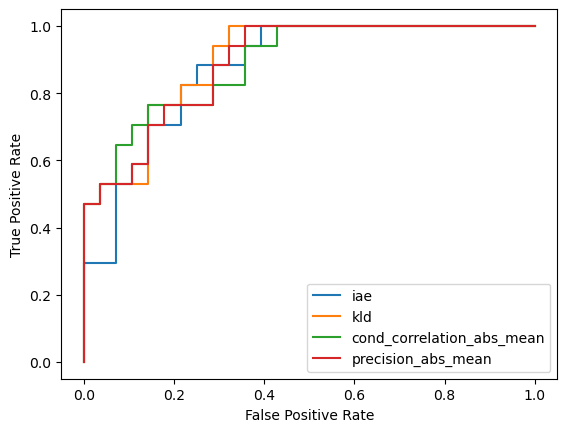

In [ ]:
fpr, tpr, thresholds = roc_curve(merged["dependence"], merged["iae"])
plt.plot(fpr, tpr, label="iae")
fpr, tpr, thresholds = roc_curve(merged["dependence"], merged["kld"])
plt.plot(fpr, tpr, label="kld")
fpr, tpr, thresholds = roc_curve(merged["dependence"], merged["cond_correlation_abs_mean"])
plt.plot(fpr, tpr, label="cond_correlation_abs_mean")
fpr, tpr, thresholds = roc_curve(merged["dependence"], merged["precision_abs_mean"])
plt.plot(fpr, tpr, label="precision_abs_mean")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

#### Looking at the model splines

In [32]:
#_ = plot_splines(model.transformation,simulated_data_train)

In [ ]:
#_ = plot_splines(model.decorrelation_layers[0],simulated_data_train)

In [ ]:
#_ = plot_splines(model.decorrelation_layers[1],simulated_data_train)

In [ ]:
#_ = plot_splines(model.decorrelation_layers[2],simulated_data_train)